In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from noise_scheduler import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding


from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

import json

from sklearn.metrics import classification_report, roc_curve, auc

import seaborn as sns


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from noise_scheduler import SimplexNoiseScheduler


# Results 

## WSD107 
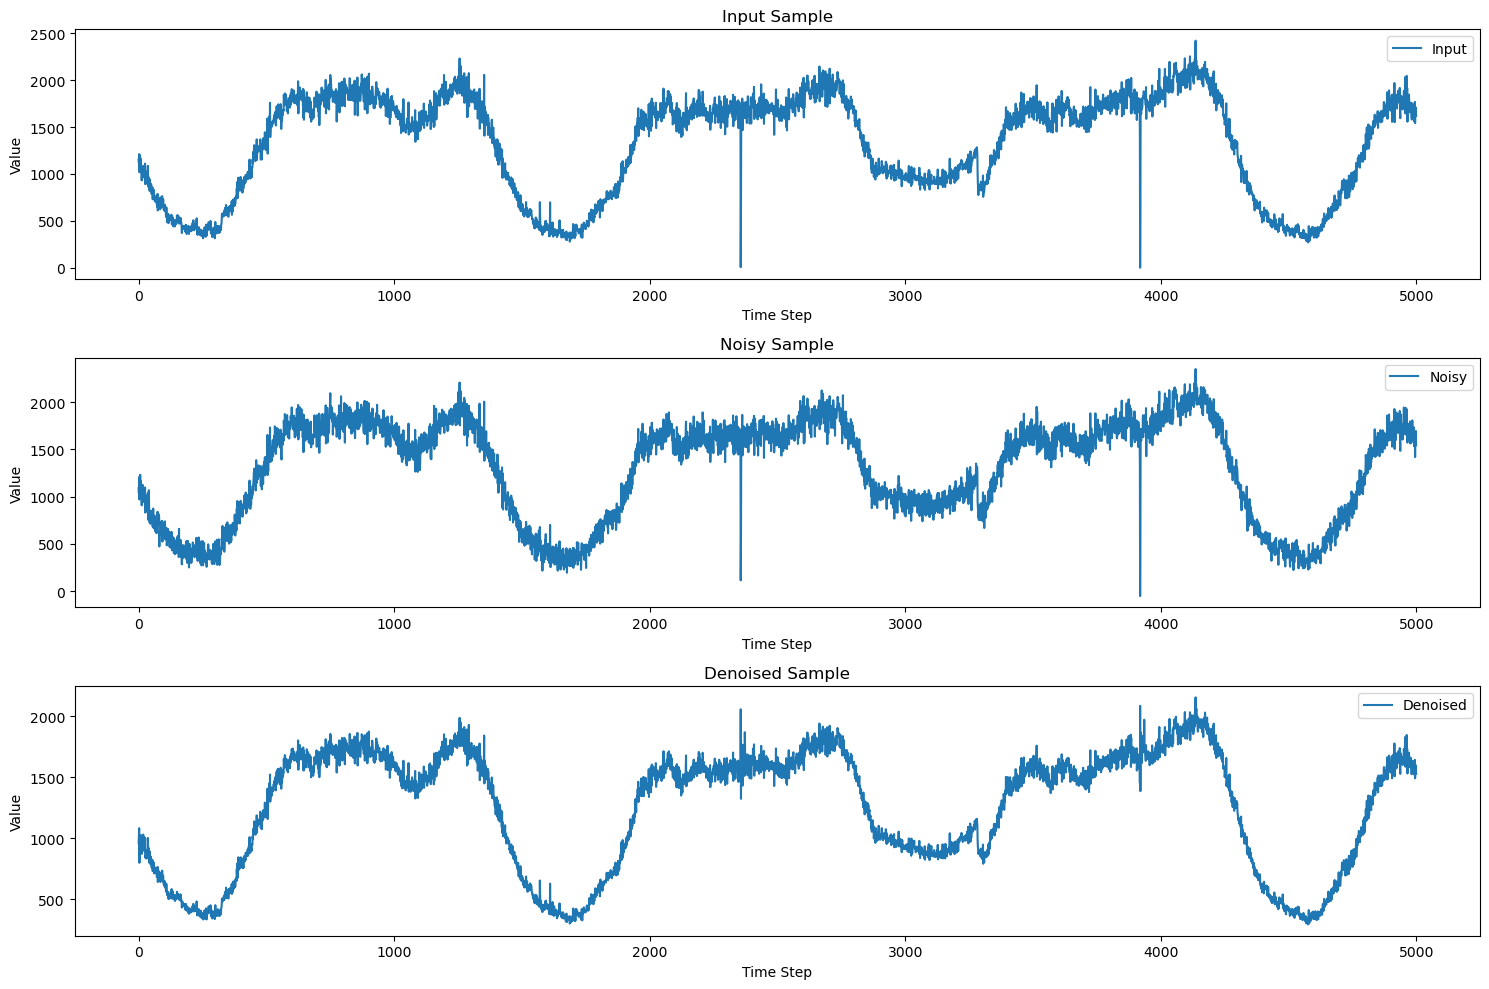

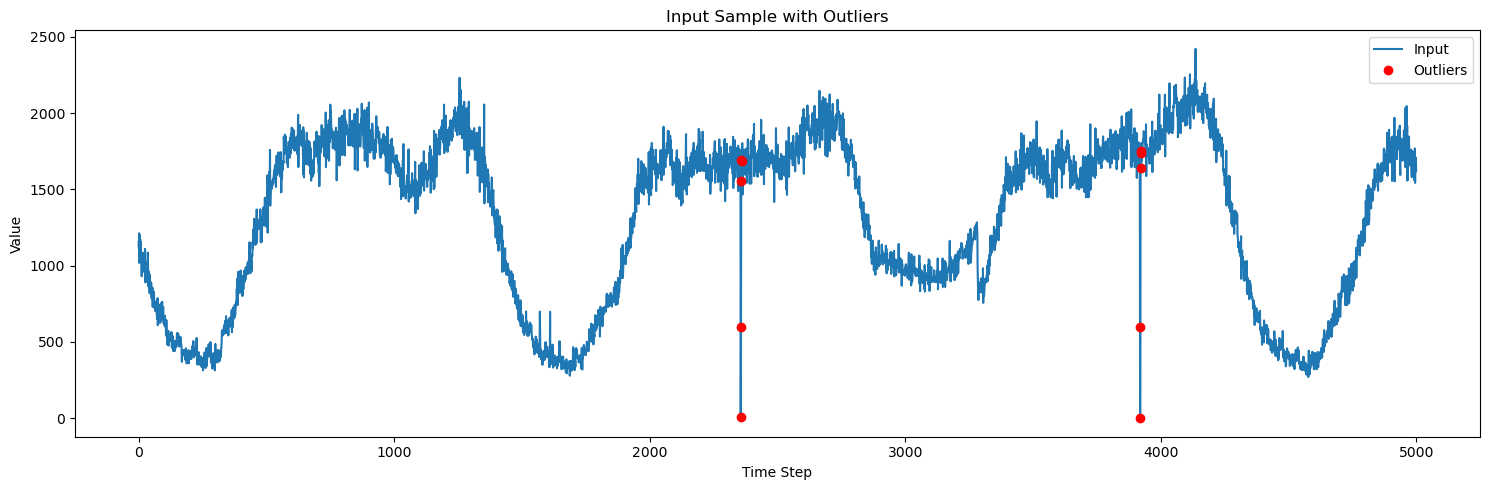

eval timesteps tensor([ 63,   2, 619,  93, 584, 615,  78,  22, 698, 209, 649, 509, 578, 165,
        598, 285])
Best threshold: tensor(369.5092)
Best F1 score: 0.21052631578947367
Best AUPRC score: 0.12364705882352942
Best Precision score: 1.0
Best Recall score: 0.11764705882352941
Best threshold: tensor(369.5092)
Best F1 score: 0.19607843137254902
Best AUPRC score: 0.11689565217391304
Best Precision score: 1.0
Best Recall score: 0.10869565217391304
Best threshold: tensor(369.5092)
Best F1 score: 0.16129032258064516
Best AUPRC score: 0.0846047619047619
Best Precision score: 0.8333333333333334
Best Recall score: 0.08928571428571429
Best threshold: tensor(369.5092)
Best F1 score: 0.16393442622950818
Best AUPRC score: 0.09948571428571429
Best Precision score: 1.0
Best Recall score: 0.08928571428571429
Best threshold: tensor(369.5092)
Best F1 score: 0.15384615384615385
Best AUPRC score: 0.10093333333333332
Best Precision score: 1.0
Best Recall score: 0.08333333333333333
Best threshold: tensor(369.5092)
Best F1 score: 0.1553398058252427
Best AUPRC score: 0.10161052631578947
Best Precision score: 1.0
Best Recall score: 0.08421052631578947
Best threshold: tensor(369.5092)
Best F1 score: 0.1553398058252427
Best AUPRC score: 0.10161052631578947
Best Precision score: 1.0
Best Recall score: 0.08421052631578947
Best threshold: tensor(369.5092)
Best F1 score: 0.1694915254237288
Best AUPRC score: 0.1121925925925926
Best Precision score: 1.0
Best Recall score: 0.09259259259259259
Best threshold: tensor(369.5092)
Best F1 score: 0.17204301075268819
Best AUPRC score: 0.09985608465608466
Best Precision score: 0.8888888888888888
Best Recall score: 0.09523809523809523
Best threshold: tensor(263.9352)
Best F1 score: 0.17391304347826086
Best AUPRC score: 0.11043809523809524
Best Precision score: 1.0
Best Recall score: 0.09523809523809523
Best threshold: tensor(369.5092)
Best F1 score: 0.17391304347826086
Best AUPRC score: 0.11043809523809524
Best Precision score: 1.0
Best Recall score: 0.09523809523809523
Best threshold: tensor(369.5092)
Best F1 score: 0.175
Best AUPRC score: 0.09806944444444445
Best Precision score: 0.875
Best Recall score: 0.09722222222222222
Best threshold: tensor(263.9352)
Best F1 score: 0.2028985507246377
Best AUPRC score: 0.1239032258064516
Best Precision score: 1.0
Best Recall score: 0.11290322580645161
Best threshold: tensor(369.5092)
Best F1 score: 0.2222222222222222
Best AUPRC score: 0.1376
Best Precision score: 1.0
Best Recall score: 0.125
Best threshold: tensor(369.5092)
Best F1 score: 0.3076923076923077
Best AUPRC score: 0.1659142857142857
Best Precision score: 0.8571428571428571
Best Recall score: 0.1875
Best threshold: tensor(263.9352)
Best F1 score: 0.2962962962962963
Best AUPRC score: 0.17771304347826086
Best Precision score: 1.0
Best Recall score: 0.17391304347826086
F1 score: 0.1931140788460761
AUPRC score: 0.11655702752007133
Precision score: 0.9658978174603176
Recall score: 0.10821961845922476

## NAB
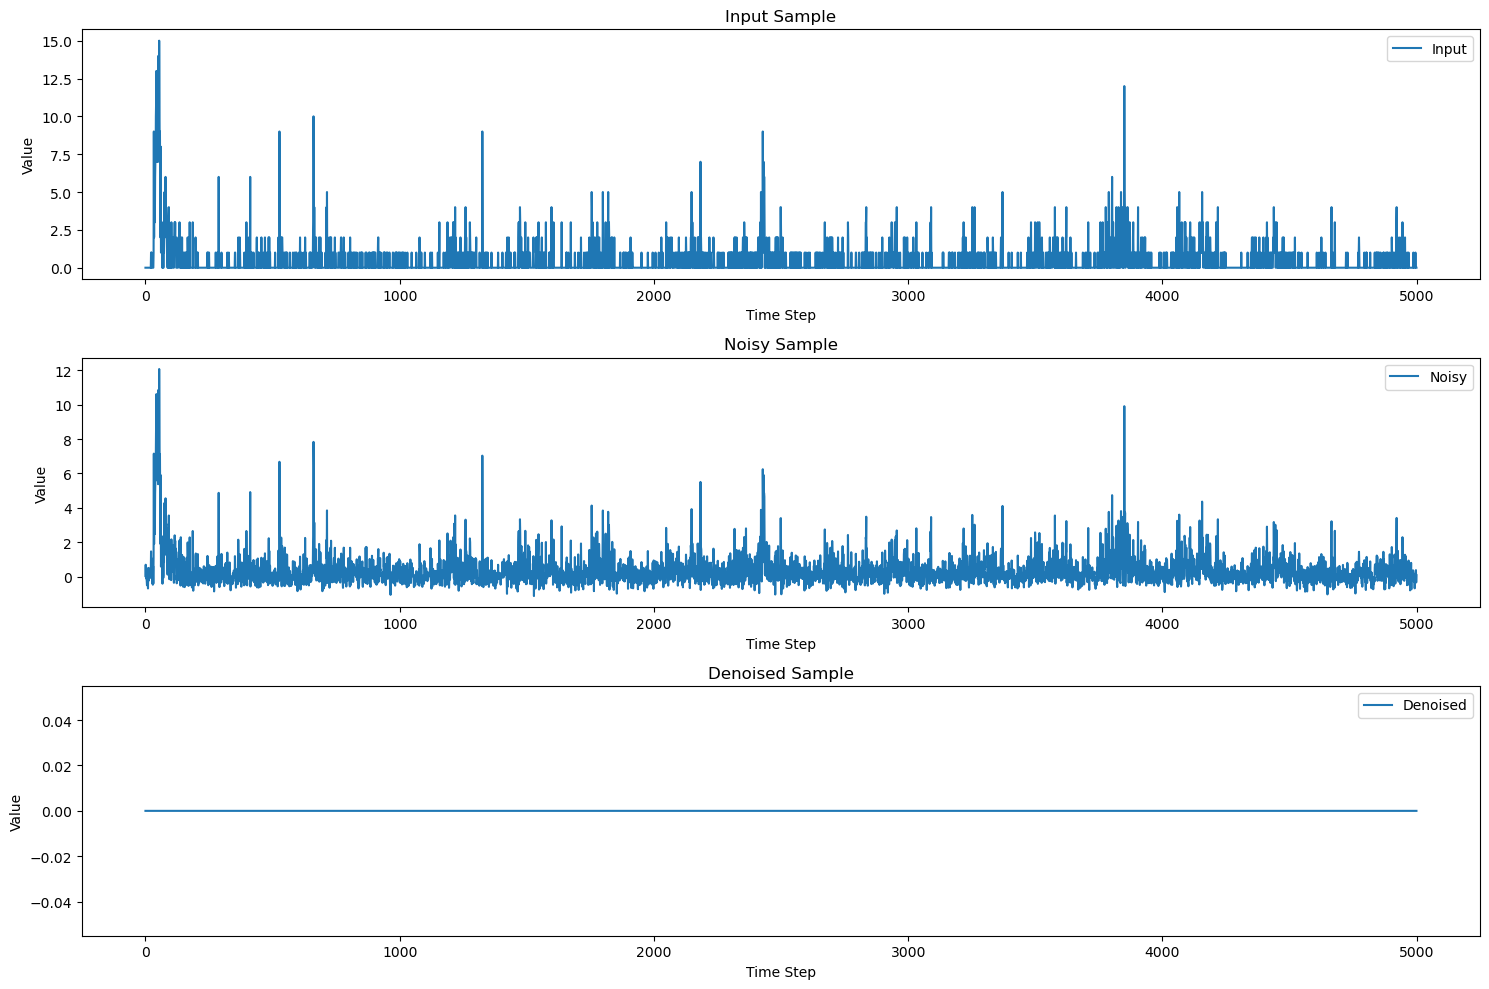
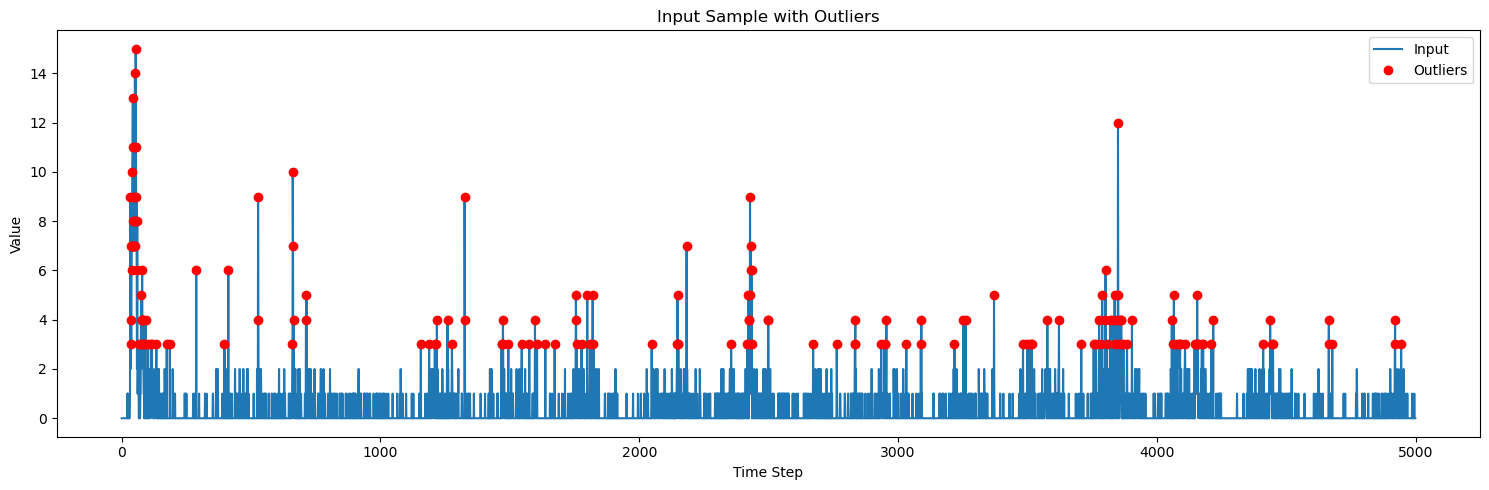
eval timesteps tensor([634, 451, 626, 721])
Best threshold: tensor(2.0974)
Best F1 score: 0.21176470588235294
Best AUPRC score: 0.08645831779102034
Best Precision score: 0.25280898876404495
Best Recall score: 0.18218623481781376
Best threshold: tensor(1.1039)
Best F1 score: 0.027586206896551724
Best AUPRC score: 0.015505956613219183
Best Precision score: 0.01675977653631285
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.5520)
Best F1 score: 0.1319073083778966
Best AUPRC score: 0.08149127348806288
Best Precision score: 0.08638132295719844
Best Recall score: 0.27889447236180903
Best threshold: tensor(0.5520)
Best F1 score: 0.13012895662368112
Best AUPRC score: 0.08106765017749298
Best Precision score: 0.08486238532110092
Best Recall score: 0.27889447236180903
F1 score: 0.1253467944451206
AUPRC score: 0.06613079951744885
Precision score: 0.11020311839466429
Recall score: 0.20447431436587743

# Complete Evaluation

In [3]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [4]:
# training testing imports 
import train_test_fonctions
from train_test_fonctions import calculate_f1_auprc_score, plot_samples, plot_predictions, trainer, tester, train_tracker, z_score_outliers, modified_z_score_outliers, iqr_outliers, iqr_collective_outliers
from train_test_fonctions import train_model, test_model, process_directory, trainer_all_in_one

## WSD dataset

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [6]:
import os

data_folder = "../datasets/UTS/WSD"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(losses,config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


{'data_path': '../datasets/UTS/WSD/0', 'output_dir': 'output_WSD/0', 'train_batch_size': 16, 'eval_batch_size': 1, 'num_epochs': 5, 'learning_rate': 0.0001, 'num_timesteps': 1000, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.0001, 'beta_end': 0.02, 'save_model_epochs': 1}
../datasets/UTS/WSD/0
Training model...


100%|██████████| 5/5 [00:57<00:00, 11.54s/it]


TypeError: train_tracker() missing 1 required positional argument: 'dataset'

# NAB dataset - all in one 

In [9]:
# config for NAB dataset
base_config = {
  "data_path":  "../datasets/UTS/NAB",
  "output_dir": "output_NAB_simplex1",
  "train_batch_size": 2,
  "eval_batch_size": 1,
  "num_epochs": 15,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.5,
  "save_model_epochs": 1
}

sequence_length = 3000
input_size = 1  # Assuming 1D time series data
stride = 100


In [10]:
# all in one training and testing
import os
    
config = Config(base_config)

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32,64, 128, 256,128,64,32,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)



noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = "../datasets/UTS/NAB"

#================================================================================================
# train the model and test it

model, losses = trainer_all_in_one(sequence_length, stride, base_config, config, model, noise_scheduler, data_folder)


Training model...


  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': 60865.79296875, 'epoch': 0}
{'loss': 24527.263671875, 'epoch': 0}
{'loss': 29.38969612121582, 'epoch': 0}
{'loss': 0.8691521883010864, 'epoch': 0}
{'loss': 704.4208984375, 'epoch': 0}
{'loss': 287.07135009765625, 'epoch': 0}
{'loss': 24.655052185058594, 'epoch': 0}
{'loss': 545.333251953125, 'epoch': 0}
{'loss': 2.190066337585449, 'epoch': 0}


  7%|▋         | 1/15 [00:20<04:44, 20.33s/it]

{'loss': 74.08454132080078, 'epoch': 0}
{'loss': 38154.76953125, 'epoch': 1}
{'loss': 1096.0751953125, 'epoch': 1}
{'loss': 47.994300842285156, 'epoch': 1}
{'loss': 0.8669137358665466, 'epoch': 1}
{'loss': 614.337890625, 'epoch': 1}
{'loss': 184.1507568359375, 'epoch': 1}
{'loss': 22.43218231201172, 'epoch': 1}
{'loss': 553.364013671875, 'epoch': 1}
{'loss': 5.206684589385986, 'epoch': 1}


 13%|█▎        | 2/15 [00:41<04:33, 21.00s/it]

{'loss': 153.90061950683594, 'epoch': 1}
{'loss': 34672.1484375, 'epoch': 2}
{'loss': 2738.6474609375, 'epoch': 2}
{'loss': 50.864952087402344, 'epoch': 2}
{'loss': 0.8198360800743103, 'epoch': 2}
{'loss': 524.5823974609375, 'epoch': 2}
{'loss': 295.9222412109375, 'epoch': 2}
{'loss': 13.85953426361084, 'epoch': 2}
{'loss': 225.99200439453125, 'epoch': 2}
{'loss': 9.978376388549805, 'epoch': 2}


 20%|██        | 3/15 [01:02<04:10, 20.89s/it]

{'loss': 120.44343566894531, 'epoch': 2}
{'loss': 39148.78515625, 'epoch': 3}
{'loss': 2220.30810546875, 'epoch': 3}
{'loss': 13.64969253540039, 'epoch': 3}
{'loss': 0.7934399247169495, 'epoch': 3}
{'loss': 446.03033447265625, 'epoch': 3}
{'loss': 197.10604858398438, 'epoch': 3}
{'loss': 19.931795120239258, 'epoch': 3}
{'loss': 1849.04345703125, 'epoch': 3}
{'loss': 7.713619232177734, 'epoch': 3}


 27%|██▋       | 4/15 [01:23<03:50, 20.93s/it]

{'loss': 217.80384826660156, 'epoch': 3}
{'loss': 59384.94921875, 'epoch': 4}
{'loss': 3191.123291015625, 'epoch': 4}
{'loss': 45.0606575012207, 'epoch': 4}
{'loss': 0.4431857764720917, 'epoch': 4}
{'loss': 570.7311401367188, 'epoch': 4}
{'loss': 533.0633544921875, 'epoch': 4}
{'loss': 22.463916778564453, 'epoch': 4}
{'loss': 45.09138488769531, 'epoch': 4}
{'loss': 7.3214616775512695, 'epoch': 4}


 33%|███▎      | 5/15 [01:44<03:30, 21.08s/it]

{'loss': 208.21551513671875, 'epoch': 4}
{'loss': 48683.0703125, 'epoch': 5}
{'loss': 2389.187255859375, 'epoch': 5}
{'loss': 46.75982666015625, 'epoch': 5}
{'loss': 0.8609523773193359, 'epoch': 5}
{'loss': 409.8150939941406, 'epoch': 5}
{'loss': 467.33587646484375, 'epoch': 5}
{'loss': 4.517544269561768, 'epoch': 5}
{'loss': 510.41094970703125, 'epoch': 5}
{'loss': 10.982706069946289, 'epoch': 5}


 40%|████      | 6/15 [02:05<03:08, 20.92s/it]

{'loss': 218.3915252685547, 'epoch': 5}
{'loss': 59880.66015625, 'epoch': 6}
{'loss': 2367.15087890625, 'epoch': 6}
{'loss': 20.401351928710938, 'epoch': 6}
{'loss': 1.3376468420028687, 'epoch': 6}
{'loss': 605.9390258789062, 'epoch': 6}
{'loss': 499.70379638671875, 'epoch': 6}
{'loss': 24.164783477783203, 'epoch': 6}
{'loss': 550.4300537109375, 'epoch': 6}
{'loss': 8.688101768493652, 'epoch': 6}


 47%|████▋     | 7/15 [02:26<02:47, 21.00s/it]

{'loss': 44.823692321777344, 'epoch': 6}
{'loss': 4801.40625, 'epoch': 7}
{'loss': 935.8399047851562, 'epoch': 7}
{'loss': 50.61948776245117, 'epoch': 7}
{'loss': 0.6896324157714844, 'epoch': 7}
{'loss': 644.3756713867188, 'epoch': 7}
{'loss': 211.10459899902344, 'epoch': 7}
{'loss': 22.547168731689453, 'epoch': 7}
{'loss': 488.8071594238281, 'epoch': 7}
{'loss': 7.979433059692383, 'epoch': 7}


 53%|█████▎    | 8/15 [02:47<02:25, 20.83s/it]

{'loss': 176.5575408935547, 'epoch': 7}
{'loss': 53864.8515625, 'epoch': 8}
{'loss': 7993.98388671875, 'epoch': 8}
{'loss': 50.10401916503906, 'epoch': 8}
{'loss': 1.3563027381896973, 'epoch': 8}
{'loss': 721.2034912109375, 'epoch': 8}
{'loss': 511.802001953125, 'epoch': 8}
{'loss': 9.444367408752441, 'epoch': 8}
{'loss': 458.9817199707031, 'epoch': 8}
{'loss': 5.720434188842773, 'epoch': 8}


 60%|██████    | 9/15 [03:07<02:05, 20.83s/it]

{'loss': 212.89068603515625, 'epoch': 8}
{'loss': 43258.1484375, 'epoch': 9}
{'loss': 2923.43603515625, 'epoch': 9}
{'loss': 26.268457412719727, 'epoch': 9}
{'loss': 1.9746917486190796, 'epoch': 9}
{'loss': 463.1286315917969, 'epoch': 9}
{'loss': 542.6887817382812, 'epoch': 9}
{'loss': 7.442208290100098, 'epoch': 9}
{'loss': 419.3575744628906, 'epoch': 9}
{'loss': 10.95457649230957, 'epoch': 9}


 67%|██████▋   | 10/15 [03:29<01:44, 20.92s/it]

{'loss': 187.9306182861328, 'epoch': 9}
{'loss': 57571.359375, 'epoch': 10}
{'loss': 1602.8131103515625, 'epoch': 10}
{'loss': 48.75001525878906, 'epoch': 10}
{'loss': 3.555738925933838, 'epoch': 10}
{'loss': 322.1977233886719, 'epoch': 10}
{'loss': 33.438323974609375, 'epoch': 10}
{'loss': 20.40374755859375, 'epoch': 10}
{'loss': 558.6577758789062, 'epoch': 10}
{'loss': 13.136161804199219, 'epoch': 10}


 73%|███████▎  | 11/15 [03:50<01:23, 20.95s/it]

{'loss': 135.39854431152344, 'epoch': 10}
{'loss': 61269.2890625, 'epoch': 11}
{'loss': 2475.038330078125, 'epoch': 11}
{'loss': 106.72991943359375, 'epoch': 11}
{'loss': 7.476700305938721, 'epoch': 11}
{'loss': 668.1949462890625, 'epoch': 11}
{'loss': 328.72607421875, 'epoch': 11}
{'loss': 21.695226669311523, 'epoch': 11}
{'loss': 582.2963256835938, 'epoch': 11}
{'loss': 9.163862228393555, 'epoch': 11}


 80%|████████  | 12/15 [04:10<01:02, 20.75s/it]

{'loss': 104.9154052734375, 'epoch': 11}
{'loss': 27306.81640625, 'epoch': 12}
{'loss': 2332.4775390625, 'epoch': 12}
{'loss': 30.404483795166016, 'epoch': 12}
{'loss': 3.793119192123413, 'epoch': 12}
{'loss': 693.0880126953125, 'epoch': 12}
{'loss': 515.944091796875, 'epoch': 12}
{'loss': 20.161184310913086, 'epoch': 12}
{'loss': 587.6092529296875, 'epoch': 12}
{'loss': 8.312630653381348, 'epoch': 12}


 87%|████████▋ | 13/15 [04:31<00:41, 20.76s/it]

{'loss': 209.2786865234375, 'epoch': 12}
{'loss': 38798.26171875, 'epoch': 13}
{'loss': 2133.62939453125, 'epoch': 13}
{'loss': 30.994958877563477, 'epoch': 13}
{'loss': 5.254257678985596, 'epoch': 13}
{'loss': 368.298583984375, 'epoch': 13}
{'loss': 253.92108154296875, 'epoch': 13}
{'loss': 22.018674850463867, 'epoch': 13}
{'loss': 574.7059326171875, 'epoch': 13}
{'loss': 11.210549354553223, 'epoch': 13}


 93%|█████████▎| 14/15 [04:52<00:20, 20.91s/it]

{'loss': 190.72222900390625, 'epoch': 13}
{'loss': 60704.83203125, 'epoch': 14}
{'loss': 2855.54931640625, 'epoch': 14}
{'loss': 51.934566497802734, 'epoch': 14}
{'loss': 6.442367076873779, 'epoch': 14}
{'loss': 679.5462646484375, 'epoch': 14}
{'loss': 50.79150390625, 'epoch': 14}
{'loss': 22.6856632232666, 'epoch': 14}
{'loss': 561.1965942382812, 'epoch': 14}
{'loss': 12.37923812866211, 'epoch': 14}


100%|██████████| 15/15 [05:13<00:00, 20.92s/it]

{'loss': 218.23521423339844, 'epoch': 14}



Processing directory: Twitter_volume_AAPL
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 34.27it/s]



IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84      5602
         1.0       0.14      0.59      0.23       398

    accuracy                           0.73      6000
   macro avg       0.55      0.67      0.53      6000
weighted avg       0.91      0.73      0.80      6000

ROC AUC: 0.7128

Processing directory: Twitter_volume_AMZN
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 62.97it/s]



IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.90      0.54      0.67      5208
         1.0       0.17      0.63      0.27       792

    accuracy                           0.55      6000
   macro avg       0.54      0.58      0.47      6000
weighted avg       0.81      0.55      0.62      6000

ROC AUC: 0.6328

Processing directory: Twitter_volume_CRM
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 62.64it/s]



IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      5651
         1.0       0.28      0.39      0.33       349

    accuracy                           0.91      6000
   macro avg       0.62      0.66      0.64      6000
weighted avg       0.92      0.91      0.91      6000

ROC AUC: 0.6622

Processing directory: Twitter_volume_CVS
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 62.56it/s]



IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.78      0.01      0.02      5355
         1.0       0.11      0.98      0.19       645

    accuracy                           0.11      6000
   macro avg       0.44      0.49      0.11      6000
weighted avg       0.71      0.11      0.04      6000

ROC AUC: 0.5444

Processing directory: Twitter_volume_FB
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 61.40it/s]



IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80      5208
         1.0       0.08      0.14      0.10       792

    accuracy                           0.67      6000
   macro avg       0.47      0.45      0.45      6000
weighted avg       0.75      0.67      0.71      6000

ROC AUC: 0.4200

Processing directory: Twitter_volume_GOOG
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 62.91it/s]



IQR outliers classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89      5602
         1.0       0.24      0.86      0.38       398

    accuracy                           0.81      6000
   macro avg       0.61      0.84      0.63      6000
weighted avg       0.94      0.81      0.85      6000

ROC AUC: 0.9130

Processing directory: Twitter_volume_IBM
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 61.93it/s]
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/


IQR outliers classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      6000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93      6000
   macro avg       0.50      0.46      0.48      6000
weighted avg       1.00      0.93      0.96      6000

ROC AUC: nan

Processing directory: Twitter_volume_KO
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 61.34it/s]



IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82      4940
         1.0       0.15      0.14      0.15      1060

    accuracy                           0.71      6000
   macro avg       0.49      0.49      0.49      6000
weighted avg       0.70      0.71      0.70      6000

ROC AUC: 0.4785

Processing directory: Twitter_volume_PFE
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 58.16it/s]



IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.90      0.12      0.21      5602
         1.0       0.06      0.81      0.11       398

    accuracy                           0.17      6000
   macro avg       0.48      0.46      0.16      6000
weighted avg       0.84      0.17      0.21      6000

ROC AUC: 0.4056

Processing directory: Twitter_volume_UPS
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 60.66it/s]



IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      5682
         1.0       0.22      0.31      0.26       318

    accuracy                           0.91      6000
   macro avg       0.59      0.62      0.60      6000
weighted avg       0.92      0.91      0.91      6000

ROC AUC: 0.6946

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.78     54850
         1.0       0.12      0.49      0.19      5150

    accuracy                           0.65     60000
   macro avg       0.53      0.58      0.48     60000
weighted avg       0.86      0.65      0.73     60000



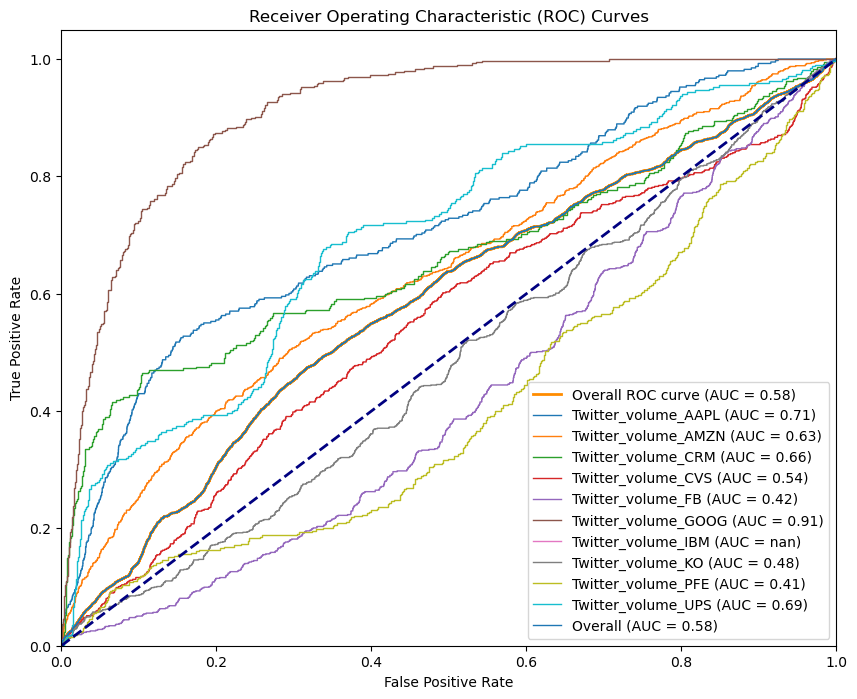


Overall ROC AUC: 0.5840


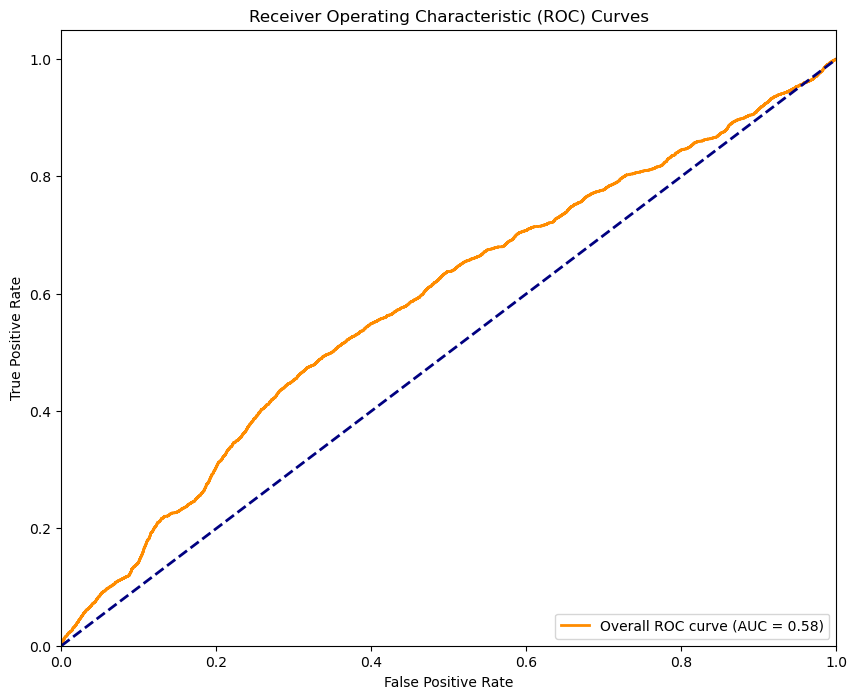

In [11]:
# evaluation with roc curve and classification report 

model.eval()
eval_batch_size = config.eval_batch_size

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        print(f"\nProcessing directory: {dir}")
    
        # change datapath in the config
        base_config["data_path"] = data_path
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length , stride=sequence_length , normalize=False)
        print("Number of batches:", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

        all_labels = []
        all_scores = []

        for step, (sample, labels) in enumerate(tqdm(test_dataloader)):
            std_data = torch.std(sample)
            
            with torch.no_grad():
                timesteps = torch.tensor([70])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                # Calculate IQR outliers
                iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
                
                labels = labels.cpu().numpy()

                # Store labels and scores
                all_labels.extend(labels.reshape(-1))
                all_scores.extend(iqr_scores.reshape(-1))

        # Calculate metrics for this directory
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        print("\nIQR outliers classification report for", dir)
        print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))
        print(f"ROC AUC: {roc_auc:.4f}")

        # Store results for this directory
        all_dir_results.append({
            'dir': dir,
            'labels': all_labels,
            'scores': all_scores,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })

# Compute overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

#save the results in a csv file
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"allinone_roc_resultsf{config.num_epochs}.csv"))

# Plot overall ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for each directory
for res in all_dir_results:
    plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_roc_curves_{config.num_epochs}.png"))
plt.show()


print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()


In [12]:
# ROC AUC score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"allin_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: nan
Median: nan
Min: nan
Max: nan


# NAB dataset - one by one 


Processing directory: Twitter_volume_AAPL


Training:   7%|▋         | 1/15 [00:02<00:31,  2.28s/it]

Epoch 1/15, Loss: 41687.7621


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.16s/it]

Epoch 2/15, Loss: 66533.0164


Training:  20%|██        | 3/15 [00:06<00:25,  2.13s/it]

Epoch 3/15, Loss: 73561.2713


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.16s/it]

Epoch 4/15, Loss: 53842.1158


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.13s/it]

Epoch 5/15, Loss: 60563.6497


Training:  40%|████      | 6/15 [00:12<00:19,  2.12s/it]

Epoch 6/15, Loss: 83061.2058


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.10s/it]

Epoch 7/15, Loss: 68535.0755


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.10s/it]

Epoch 8/15, Loss: 51121.3434


Training:  60%|██████    | 9/15 [00:19<00:12,  2.10s/it]

Epoch 9/15, Loss: 155606.0220


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.11s/it]

Epoch 10/15, Loss: 123122.6449


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.10s/it]

Epoch 11/15, Loss: 105384.9898


Training:  80%|████████  | 12/15 [00:25<00:06,  2.10s/it]

Epoch 12/15, Loss: 64729.6486


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.10s/it]

Epoch 13/15, Loss: 49228.5540


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.10s/it]

Epoch 14/15, Loss: 56838.6525


Training: 100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


Epoch 15/15, Loss: 50708.9066


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.16it/s]



Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      5602
         1.0       0.21      0.28      0.24       398

    accuracy                           0.88      6000
   macro avg       0.58      0.60      0.59      6000
weighted avg       0.90      0.88      0.89      6000

ROC AUC: 0.6001

Processing directory: Twitter_volume_AMZN


Training:   7%|▋         | 1/15 [00:02<00:29,  2.13s/it]

Epoch 1/15, Loss: 4479.5996


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.11s/it]

Epoch 2/15, Loss: 4625.7793


Training:  20%|██        | 3/15 [00:06<00:25,  2.10s/it]

Epoch 3/15, Loss: 3397.3264


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.09s/it]

Epoch 4/15, Loss: 4540.8825


Training:  33%|███▎      | 5/15 [00:10<00:20,  2.09s/it]

Epoch 5/15, Loss: 2093.2984


Training:  40%|████      | 6/15 [00:12<00:18,  2.07s/it]

Epoch 6/15, Loss: 1881.3591


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.06s/it]

Epoch 7/15, Loss: 1240.0188


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.05s/it]

Epoch 8/15, Loss: 1751.7843


Training:  60%|██████    | 9/15 [00:18<00:12,  2.06s/it]

Epoch 9/15, Loss: 1180.0261


Training:  67%|██████▋   | 10/15 [00:20<00:10,  2.07s/it]

Epoch 10/15, Loss: 1176.7030


Training:  73%|███████▎  | 11/15 [00:22<00:08,  2.09s/it]

Epoch 11/15, Loss: 1160.3674


Training:  80%|████████  | 12/15 [00:24<00:06,  2.08s/it]

Epoch 12/15, Loss: 1176.4520


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.08s/it]

Epoch 13/15, Loss: 1398.6435


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.10s/it]

Epoch 14/15, Loss: 1366.1052


Training: 100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


Epoch 15/15, Loss: 1772.4461


Testing: 100%|██████████| 2/2 [00:00<00:00, 75.42it/s]



Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      5208
         1.0       0.34      0.14      0.20       792

    accuracy                           0.85      6000
   macro avg       0.61      0.55      0.56      6000
weighted avg       0.81      0.85      0.82      6000

ROC AUC: 0.5714

Processing directory: Twitter_volume_CRM


Training:   7%|▋         | 1/15 [00:02<00:30,  2.18s/it]

Epoch 1/15, Loss: 21.5147


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.14s/it]

Epoch 2/15, Loss: 18.2089


Training:  20%|██        | 3/15 [00:06<00:25,  2.11s/it]

Epoch 3/15, Loss: 20.9614


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.10s/it]

Epoch 4/15, Loss: 20.1683


Training:  33%|███▎      | 5/15 [00:10<00:20,  2.10s/it]

Epoch 5/15, Loss: 20.8880


Training:  40%|████      | 6/15 [00:12<00:19,  2.15s/it]

Epoch 6/15, Loss: 21.6204


Training:  47%|████▋     | 7/15 [00:15<00:18,  2.35s/it]

Epoch 7/15, Loss: 21.7969


Training:  53%|█████▎    | 8/15 [00:18<00:17,  2.44s/it]

Epoch 8/15, Loss: 21.0138


Training:  60%|██████    | 9/15 [00:20<00:13,  2.33s/it]

Epoch 9/15, Loss: 22.0368


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.26s/it]

Epoch 10/15, Loss: 21.8233


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.22s/it]

Epoch 11/15, Loss: 21.5127


Training:  80%|████████  | 12/15 [00:26<00:06,  2.18s/it]

Epoch 12/15, Loss: 20.4226


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.16s/it]

Epoch 13/15, Loss: 19.1986


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.13s/it]

Epoch 14/15, Loss: 22.8175


Training: 100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


Epoch 15/15, Loss: 23.5379


Testing: 100%|██████████| 2/2 [00:00<00:00, 58.56it/s]



Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      5651
         1.0       0.26      0.43      0.32       349

    accuracy                           0.89      6000
   macro avg       0.61      0.68      0.63      6000
weighted avg       0.92      0.89      0.91      6000

ROC AUC: 0.7204

Processing directory: Twitter_volume_CVS


Training:   7%|▋         | 1/15 [00:02<00:31,  2.27s/it]

Epoch 1/15, Loss: 1.0489


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.16s/it]

Epoch 2/15, Loss: 1.0020


Training:  20%|██        | 3/15 [00:06<00:26,  2.20s/it]

Epoch 3/15, Loss: 1.0020


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.16s/it]

Epoch 4/15, Loss: 1.0020


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.13s/it]

Epoch 5/15, Loss: 1.0020


Training:  40%|████      | 6/15 [00:12<00:19,  2.11s/it]

Epoch 6/15, Loss: 1.0020


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.09s/it]

Epoch 7/15, Loss: 1.0020


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.08s/it]

Epoch 8/15, Loss: 1.0020


Training:  60%|██████    | 9/15 [00:19<00:12,  2.12s/it]

Epoch 9/15, Loss: 1.0020


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.10s/it]

Epoch 10/15, Loss: 1.0020


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.07s/it]

Epoch 11/15, Loss: 1.0020


Training:  80%|████████  | 12/15 [00:25<00:06,  2.10s/it]

Epoch 12/15, Loss: 1.0020


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.08s/it]

Epoch 13/15, Loss: 1.0020


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.08s/it]

Epoch 14/15, Loss: 1.0020


Training: 100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


Epoch 15/15, Loss: 1.0020


Testing: 100%|██████████| 2/2 [00:00<00:00, 57.51it/s]



Classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      5355
         1.0       0.22      0.17      0.19       645

    accuracy                           0.85      6000
   macro avg       0.56      0.55      0.55      6000
weighted avg       0.83      0.85      0.84      6000

ROC AUC: 0.5495

Processing directory: Twitter_volume_FB


Training:   7%|▋         | 1/15 [00:02<00:31,  2.22s/it]

Epoch 1/15, Loss: 481.1755


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.11s/it]

Epoch 2/15, Loss: 459.7653


Training:  20%|██        | 3/15 [00:06<00:24,  2.08s/it]

Epoch 3/15, Loss: 379.7845


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.09s/it]

Epoch 4/15, Loss: 221.4196


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.11s/it]

Epoch 5/15, Loss: 227.1480


Training:  40%|████      | 6/15 [00:12<00:19,  2.14s/it]

Epoch 6/15, Loss: 218.6060


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.12s/it]

Epoch 7/15, Loss: 201.7687


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.11s/it]

Epoch 8/15, Loss: 193.6296


Training:  60%|██████    | 9/15 [00:19<00:12,  2.10s/it]

Epoch 9/15, Loss: 224.5789


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.10s/it]

Epoch 10/15, Loss: 213.3154


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.10s/it]

Epoch 11/15, Loss: 209.3721


Training:  80%|████████  | 12/15 [00:25<00:06,  2.10s/it]

Epoch 12/15, Loss: 202.2517


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.10s/it]

Epoch 13/15, Loss: 176.2628


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.20s/it]

Epoch 14/15, Loss: 196.5585


Training: 100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


Epoch 15/15, Loss: 282.4535


Testing: 100%|██████████| 2/2 [00:00<00:00, 58.26it/s]



Classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      5208
         1.0       0.06      0.04      0.05       792

    accuracy                           0.80      6000
   macro avg       0.46      0.48      0.47      6000
weighted avg       0.76      0.80      0.78      6000

ROC AUC: 0.4751

Processing directory: Twitter_volume_GOOG


Training:   7%|▋         | 1/15 [00:02<00:29,  2.13s/it]

Epoch 1/15, Loss: 493.3830


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.22s/it]

Epoch 2/15, Loss: 356.5426


Training:  20%|██        | 3/15 [00:06<00:27,  2.28s/it]

Epoch 3/15, Loss: 537.1737


Training:  27%|██▋       | 4/15 [00:08<00:24,  2.21s/it]

Epoch 4/15, Loss: 303.1616


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.17s/it]

Epoch 5/15, Loss: 304.7519


Training:  40%|████      | 6/15 [00:13<00:19,  2.14s/it]

Epoch 6/15, Loss: 353.8977


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.14s/it]

Epoch 7/15, Loss: 348.2477


Training:  53%|█████▎    | 8/15 [00:17<00:14,  2.14s/it]

Epoch 8/15, Loss: 397.3041


Training:  60%|██████    | 9/15 [00:19<00:12,  2.12s/it]

Epoch 9/15, Loss: 377.5023


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.13s/it]

Epoch 10/15, Loss: 598.5908


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.12s/it]

Epoch 11/15, Loss: 538.0513


Training:  80%|████████  | 12/15 [00:25<00:06,  2.14s/it]

Epoch 12/15, Loss: 367.8697


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.12s/it]

Epoch 13/15, Loss: 358.5530


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.11s/it]

Epoch 14/15, Loss: 344.7652


Training: 100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch 15/15, Loss: 313.9530


Testing: 100%|██████████| 2/2 [00:00<00:00, 60.42it/s]



Classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5602
         1.0       0.45      0.51      0.48       398

    accuracy                           0.93      6000
   macro avg       0.71      0.73      0.72      6000
weighted avg       0.93      0.93      0.93      6000

ROC AUC: 0.7821

Processing directory: Twitter_volume_IBM


Training:   7%|▋         | 1/15 [00:02<00:30,  2.15s/it]

Epoch 1/15, Loss: 29.5893


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.12s/it]

Epoch 2/15, Loss: 16.6797


Training:  20%|██        | 3/15 [00:06<00:25,  2.12s/it]

Epoch 3/15, Loss: 14.3594


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.12s/it]

Epoch 4/15, Loss: 14.1958


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.10s/it]

Epoch 5/15, Loss: 16.9449


Training:  40%|████      | 6/15 [00:12<00:18,  2.10s/it]

Epoch 6/15, Loss: 14.9782


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.09s/it]

Epoch 7/15, Loss: 13.8123


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.12s/it]

Epoch 8/15, Loss: 14.3298


Training:  60%|██████    | 9/15 [00:18<00:12,  2.11s/it]

Epoch 9/15, Loss: 13.9014


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.10s/it]

Epoch 10/15, Loss: 14.2787


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.11s/it]

Epoch 11/15, Loss: 14.8273


Training:  80%|████████  | 12/15 [00:25<00:06,  2.19s/it]

Epoch 12/15, Loss: 13.2573


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.17s/it]

Epoch 13/15, Loss: 14.9879


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.15s/it]

Epoch 14/15, Loss: 13.3873


Training: 100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


Epoch 15/15, Loss: 14.3269


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.32it/s]
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-


Classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      6000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93      6000
   macro avg       0.50      0.46      0.48      6000
weighted avg       1.00      0.93      0.96      6000

ROC AUC: nan

Processing directory: Twitter_volume_KO


Training:   7%|▋         | 1/15 [00:02<00:37,  2.66s/it]

Epoch 1/15, Loss: 304.0536


Training:  13%|█▎        | 2/15 [00:05<00:34,  2.62s/it]

Epoch 2/15, Loss: 197.9860


Training:  20%|██        | 3/15 [00:07<00:28,  2.38s/it]

Epoch 3/15, Loss: 225.5587


Training:  27%|██▋       | 4/15 [00:09<00:24,  2.27s/it]

Epoch 4/15, Loss: 200.5349


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.20s/it]

Epoch 5/15, Loss: 209.6855


Training:  40%|████      | 6/15 [00:13<00:19,  2.17s/it]

Epoch 6/15, Loss: 215.9107


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.15s/it]

Epoch 7/15, Loss: 270.8671


Training:  53%|█████▎    | 8/15 [00:18<00:15,  2.23s/it]

Epoch 8/15, Loss: 196.8648


Training:  60%|██████    | 9/15 [00:20<00:13,  2.19s/it]

Epoch 9/15, Loss: 162.4031


Training:  67%|██████▋   | 10/15 [00:22<00:10,  2.17s/it]

Epoch 10/15, Loss: 227.8124


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.14s/it]

Epoch 11/15, Loss: 271.0785


Training:  80%|████████  | 12/15 [00:26<00:06,  2.12s/it]

Epoch 12/15, Loss: 282.0802


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.11s/it]

Epoch 13/15, Loss: 204.5739


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.10s/it]

Epoch 14/15, Loss: 181.3858


Training: 100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


Epoch 15/15, Loss: 180.7106


Testing: 100%|██████████| 2/2 [00:00<00:00, 55.97it/s]



Classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.87      4940
         1.0       0.17      0.08      0.11      1060

    accuracy                           0.77      6000
   macro avg       0.49      0.50      0.49      6000
weighted avg       0.71      0.77      0.73      6000

ROC AUC: 0.4873

Processing directory: Twitter_volume_PFE


Training:   7%|▋         | 1/15 [00:02<00:32,  2.34s/it]

Epoch 1/15, Loss: 2.4310


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.19s/it]

Epoch 2/15, Loss: 2.1725


Training:  20%|██        | 3/15 [00:06<00:25,  2.15s/it]

Epoch 3/15, Loss: 2.0566


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.15s/it]

Epoch 4/15, Loss: 1.9697


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.24s/it]

Epoch 5/15, Loss: 1.9801


Training:  40%|████      | 6/15 [00:13<00:20,  2.28s/it]

Epoch 6/15, Loss: 1.9440


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.22s/it]

Epoch 7/15, Loss: 1.9766


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.17s/it]

Epoch 8/15, Loss: 1.9056


Training:  60%|██████    | 9/15 [00:19<00:12,  2.14s/it]

Epoch 9/15, Loss: 1.8920


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.12s/it]

Epoch 10/15, Loss: 1.9928


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.11s/it]

Epoch 11/15, Loss: 1.9991


Training:  80%|████████  | 12/15 [00:25<00:06,  2.10s/it]

Epoch 12/15, Loss: 2.0899


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.09s/it]

Epoch 13/15, Loss: 1.9137


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.09s/it]

Epoch 14/15, Loss: 1.9180


Training: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


Epoch 15/15, Loss: 1.9656


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.84it/s]



Classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      5602
         1.0       0.12      0.16      0.14       398

    accuracy                           0.86      6000
   macro avg       0.53      0.54      0.53      6000
weighted avg       0.88      0.86      0.87      6000

ROC AUC: 0.5103

Processing directory: Twitter_volume_UPS


Training:   7%|▋         | 1/15 [00:02<00:30,  2.17s/it]

Epoch 1/15, Loss: 716.3652


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.13s/it]

Epoch 2/15, Loss: 720.7130


Training:  20%|██        | 3/15 [00:06<00:26,  2.18s/it]

Epoch 3/15, Loss: 671.1797


Training:  27%|██▋       | 4/15 [00:09<00:26,  2.39s/it]

Epoch 4/15, Loss: 760.6025


Training:  33%|███▎      | 5/15 [00:11<00:22,  2.29s/it]

Epoch 5/15, Loss: 631.7008


Training:  40%|████      | 6/15 [00:13<00:20,  2.26s/it]

Epoch 6/15, Loss: 724.5878


Training:  47%|████▋     | 7/15 [00:16<00:19,  2.38s/it]

Epoch 7/15, Loss: 639.8786


Training:  53%|█████▎    | 8/15 [00:18<00:16,  2.29s/it]

Epoch 8/15, Loss: 577.4698


Training:  60%|██████    | 9/15 [00:20<00:13,  2.23s/it]

Epoch 9/15, Loss: 559.4556


Training:  67%|██████▋   | 10/15 [00:22<00:10,  2.19s/it]

Epoch 10/15, Loss: 700.0854


Training:  73%|███████▎  | 11/15 [00:24<00:08,  2.17s/it]

Epoch 11/15, Loss: 524.7480


Training:  80%|████████  | 12/15 [00:26<00:06,  2.14s/it]

Epoch 12/15, Loss: 671.3966


Training:  87%|████████▋ | 13/15 [00:28<00:04,  2.14s/it]

Epoch 13/15, Loss: 502.1227


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.13s/it]

Epoch 14/15, Loss: 619.8343


Training: 100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Epoch 15/15, Loss: 616.4900


Testing: 100%|██████████| 2/2 [00:00<00:00, 58.01it/s]


Classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82      5682
         1.0       0.08      0.41      0.13       318

    accuracy                           0.70      6000
   macro avg       0.52      0.57      0.48      6000
weighted avg       0.91      0.70      0.79      6000

ROC AUC: 0.6047

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     54850
         1.0       0.16      0.19      0.18      5150

    accuracy                           0.85     60000
   macro avg       0.54      0.55      0.55     60000
weighted avg       0.86      0.85      0.85     60000




Overall ROC AUC: 0.5360


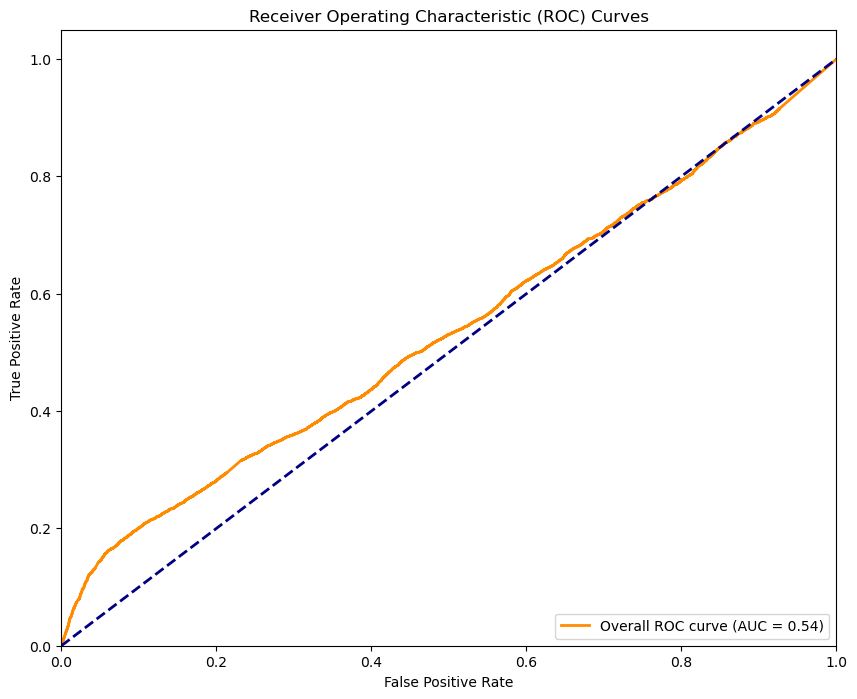

In [13]:
# Main execution
data_folder = "../datasets/UTS/NAB"



noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        result = process_directory(sequence_length, stride, input_size, data_path, base_config, TCN, noise_scheduler)
        all_dir_results.append(result)

# Compute and plot overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

# Save results to CSV
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"per_directory_roc_results_{config.num_epochs}.csv"))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for res in all_dir_results:
    if res['dir'] == 'Overall':
        plt.plot(res['fpr'], res['tpr'], color='darkorange', lw=2, label=f"Overall (AUC = {res['roc_auc']:.2f})")
    else:
        plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_roc_roc_curves_{config.num_epochs}.png"))
plt.close()

print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_oneoverall_roc_curve_{config.num_epochs}.png"))
plt.show()

In [14]:
# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"one_b_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: nan
Median: nan
Min: nan
Max: nan
